In [1]:
import torch
from transformers import BertTokenizer, BertForNextSentencePrediction, Trainer, TrainingArguments
from datasets import Dataset, load_dataset
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [3]:
# Step 1: Dataset
sentences = [
    ("The quick brown fox jumps over the lazy dog.", "The dog was not amused.", 1),
    ("The quick brown fox jumps over the lazy dog.", "I love eating pizza.", 0),
    ("She opened the door.", "She saw her friend standing there.", 1),
    ("She opened the door.", "The sky was blue.", 0),
    ("He went to the store.", "He bought some groceries.", 1),
    ("He went to the store.", "It started raining heavily.", 0)
]
dataset = Dataset.from_dict({
    "sentence1": [s[0] for s in sentences],
    "sentence2": [s[1] for s in sentences],
    "label": [s[2] for s in sentences]
})
split = dataset.train_test_split(test_size=0.2)
train_dataset, test_dataset = split["train"], split["test"]

In [5]:
# Step 2: Tokenization
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
def tokenize(example):
    return tokenizer(example["sentence1"], example["sentence2"], truncation=True, padding="max_length", max_length=128)
train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

C:\Users\gowri\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\gowri\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/4 [00:00<?, ? examples/s]

Map:   0%|          | 0/2 [00:00<?, ? examples/s]

In [7]:
# Step 3: Model & Training
model = BertForNextSentencePrediction.from_pretrained("bert-base-uncased")
from transformers import TrainingArguments
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_strategy="epoch",  # Save at the end of each epoch
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [9]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {"accuracy": accuracy_score(labels, preds)}
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)
trainer.train()

# Step 4: Evaluation
eval_results = trainer.evaluate()
print(f"\nEvaluation Results: {eval_results}")

Step,Training Loss



Evaluation Results: {'eval_loss': 1.6196564435958862, 'eval_accuracy': 0.5, 'eval_runtime': 1.0684, 'eval_samples_per_second': 1.872, 'eval_steps_per_second': 0.936, 'epoch': 3.0}


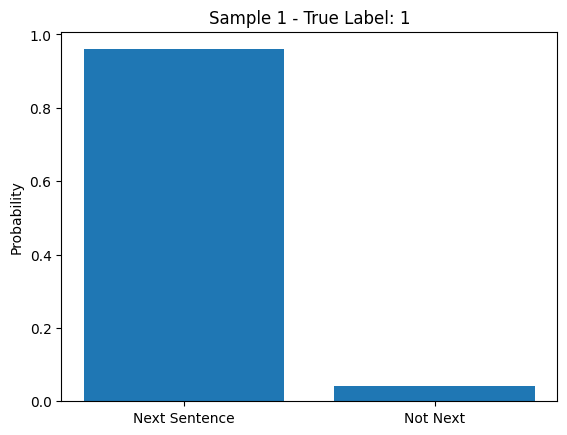

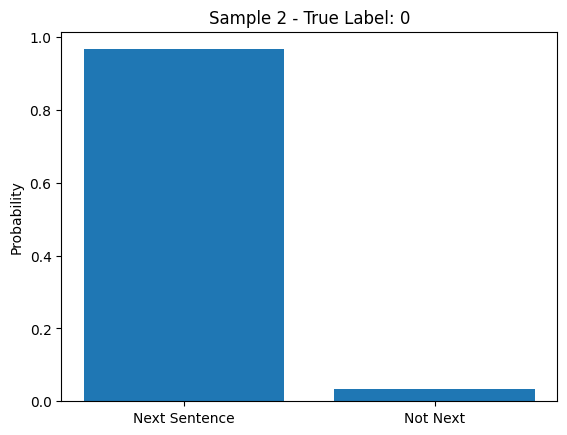

In [11]:
# Step 6: Prediction Probabilities
predictions = trainer.predict(test_dataset)
probs = torch.softmax(torch.tensor(predictions.predictions), dim=1).numpy()
for i in range(min(5, len(test_dataset))):
    plt.bar(["Next Sentence", "Not Next"], probs[i])
    plt.title(f"Sample {i+1} - True Label: {test_dataset[i]['label']}")
    plt.ylabel("Probability")
    plt.show()
